In [1]:
%autoreload 2

In [2]:
from argparse import Namespace
from collections import defaultdict
import copy
import difflib
import gzip
import itertools
import os
import pickle
import sys
import typing

from IPython.display import display, Markdown, HTML
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline
import tatsu
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tqdm.notebook as tqdm


sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS
from src.ast_counter_sampler import *
from src.ast_utils import cached_load_and_parse_games_from_file, load_games_from_file, _extract_game_id
from src import ast_printer

In [3]:
fitness_df = utils.load_fitness_data()
print(fitness_df.src_file.unique())
fitness_df.head()

['interactive-beta.pddl' 'ast-real-regrowth-samples.pddl']


,Index,src_file,game_name,domain_name,all_variables_defined,all_variables_used,all_preferences_used,setup_objects_used,no_adjacent_once,starts_and_ends_once,...,node_count_terminal_2,node_count_terminal_3,node_count_terminal_4,node_count_scoring_0,node_count_scoring_1,node_count_scoring_2,node_count_scoring_3,node_count_scoring_4,real,original_game_name
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,1.0,1.0,1.0,1.00,1.0,0.5,...,1,0,0,1,0,0,0,0,True,6172feb1665491d1efbce164-0
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,1.0,1.0,1.0,1.00,1.0,1.0,...,1,0,0,0,0,0,1,0,True,5f77754ba932fb2c4ba181d8-2
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,1.0,1.0,1.0,0.00,1.0,0.0,...,0,0,0,0,1,0,0,0,True,614b603d4da88384282967a7-3
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,1.0,1.0,1.0,0.00,1.0,1.0,...,0,0,0,1,0,0,0,0,True,5bc79f652885710001a0e82a-5
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,1.0,1.0,1.0,0.25,1.0,1.0,...,0,0,0,0,0,1,0,0,True,614dec67f6eb129c3a77defd-6


In [4]:
def create_filtered_df(df: pd.DataFrame, 
    synthetic_data_src_files: typing.Sequence[str] = ('interactive-beta.pddl', 'ast-real-regrowth-samples.pddl'),
    ) -> pd.DataFrame:
    syntethic_df = fitness_df[fitness_df.src_file.isin(synthetic_data_src_files)].reset_index(drop=True)
    syntethic_df.loc[syntethic_df.src_file == synthetic_data_src_files[0], 'real'] = 1
    return syntethic_df

filtered_fitness_df = create_filtered_df(fitness_df)

In [5]:
filtered_fitness_df.head()

,Index,src_file,game_name,domain_name,all_variables_defined,all_variables_used,all_preferences_used,setup_objects_used,no_adjacent_once,starts_and_ends_once,...,node_count_terminal_2,node_count_terminal_3,node_count_terminal_4,node_count_scoring_0,node_count_scoring_1,node_count_scoring_2,node_count_scoring_3,node_count_scoring_4,real,original_game_name
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,1.0,1.0,1.0,1.00,1.0,0.5,...,1,0,0,1,0,0,0,0,1,6172feb1665491d1efbce164-0
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,1.0,1.0,1.0,1.00,1.0,1.0,...,1,0,0,0,0,0,1,0,1,5f77754ba932fb2c4ba181d8-2
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,1.0,1.0,1.0,0.00,1.0,0.0,...,0,0,0,0,1,0,0,0,1,614b603d4da88384282967a7-3
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,1.0,1.0,1.0,0.00,1.0,1.0,...,0,0,0,1,0,0,0,0,1,5bc79f652885710001a0e82a-5
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,1.0,1.0,1.0,0.25,1.0,1.0,...,0,0,0,0,0,1,0,0,1,614dec67f6eb129c3a77defd-6


In [6]:
fake_games = filtered_fitness_df[filtered_fitness_df.src_file == 'ast-real-regrowth-samples.pddl'].reset_index()
broadcasted_original = filtered_fitness_df.loc[[filtered_fitness_df.index[(filtered_fitness_df.game_name == original_name)][0] for original_name in fake_games.original_game_name], :].reset_index()

original_regrown_diffs = (broadcasted_original.drop(NON_FEATURE_COLUMNS, axis=1) - fake_games.drop(NON_FEATURE_COLUMNS, axis=1))

unchanged_games_prop = (original_regrown_diffs.drop('index', axis=1) == 0).all(axis=1).sum() / len(original_regrown_diffs)
print(f'In {unchanged_games_prop * 100:.2f}% of the games, the regrown game was identical to the original game.')

In 4.89% of the games, the regrown game was identical to the original game.


In [7]:
never_change = (original_regrown_diffs.drop('index', axis=1) == 0).all(axis=0)
for x in never_change.index[never_change]:
    print(x)

correct_predicate_function_arity
section_without_pref_count_terminal
section_without_pref_count_scoring
arg_types_adjacent_agent_agent
arg_types_adjacent_any_object_blocks
arg_types_adjacent_any_object_colors
arg_types_adjacent_any_object_large_objects
arg_types_adjacent_any_object_ramps
arg_types_adjacent_any_object_small_objects
arg_types_adjacent_balls_building
arg_types_adjacent_blocks_any_object
arg_types_adjacent_colors_any_object
arg_types_adjacent_colors_building
arg_types_adjacent_colors_large_objects
arg_types_adjacent_colors_ramps
arg_types_adjacent_colors_room_features
arg_types_adjacent_furniture_colors
arg_types_adjacent_furniture_building
arg_types_adjacent_building_colors
arg_types_adjacent_building_large_objects
arg_types_adjacent_building_ramps
arg_types_adjacent_large_objects_agent
arg_types_adjacent_large_objects_any_object
arg_types_adjacent_large_objects_colors
arg_types_adjacent_large_objects_building
arg_types_adjacent_large_objects_ramps
arg_types_adjacent_ramp

In [8]:
sum(never_change)

150

In [9]:
original_df = filtered_fitness_df[filtered_fitness_df.src_file == 'interactive-beta.pddl'].reset_index(drop=True)
arr = np.array(original_df.all_variables_used) 
ind = np.where(arr != 1)[0]
print(ind)
original_df.iloc[ind, :]

[]


,Index,src_file,game_name,domain_name,all_variables_defined,all_variables_used,all_preferences_used,setup_objects_used,no_adjacent_once,starts_and_ends_once,...,node_count_terminal_2,node_count_terminal_3,node_count_terminal_4,node_count_scoring_0,node_count_scoring_1,node_count_scoring_2,node_count_scoring_3,node_count_scoring_4,real,original_game_name


# Synthetic model-fitting experiment approach
We have a large dataset now, I can try to cross-validate over some of the choices I might make:
* Loss function
* Parameters of each loss function (margin, etc.)
* Batch size
* Number of negative examples sampled per iteration
* Regularization strength?
* ...?



In [11]:
test_param_grid = [
    {
        'fitness__loss_function': [utils.fitness_softmin_loss], # [utils.fitness_hinge_loss_with_cross_example],
        'fitness__weight_decay': [0.0, 0.25, 1, 2],  
        # 'fitness__margin': [1, 2, 4, 8],
        'fitness__beta': [0.25, 1, 2, 4],
        'fitness__lr':  [1e-1, 3e-2, 1e-2, 3e-3],  # [1e-1, 3e-2, 1e-2, 3e-3],
        'fitness__k': [4, 8, 16, 32, 64],
        'fitness__batch_size': [2, 4, 8, 16],  # [1, 4, 8, 16],
        # 'fitness__alpha': [0, 0.25, 0.5, 0.75, 1], # [0, 0.1, 0.2, 0.3],  #
    },
    # {
    # #     'fitness__loss_function': [utils.fitness_log_loss],
    # #     'fitness__weight_decay': [0.0, 0.125, 0.25, 0.5, 1],  
    # #     'fitness__lr': [1e-2, 3e-3, 1e-3, 3e-4],
    # #     'fitness__k': [16, 32, 64, 128],
    # #     'fitness__batch_size': [1, 4, 8, 16],
    # # },
    # # {
    # #     'fitness__loss_function': [utils.fitness_square_square_loss],
    # #     'fitness__weight_decay': [0.0, 0.125, 0.25, 0.5, 1],  
    # #     'fitness__margin': [1, 2, 4],
    # #     'fitness__lr': [1e-2, 3e-3, 1e-3, 3e-4],
    # #     'fitness__k': [16, 32, 64, 128],
    # #     'fitness__batch_size': [1, 4, 8, 16],
    # },
    
]

all_feature_columns = [c for c in filtered_fitness_df.columns if c not in NON_FEATURE_COLUMNS]
model_kwargs = dict(output_activation=nn.Identity())
train_kwargs = dict()
cv_kwargs = dict(refit='single_game_rank')
scoring = utils.build_multiple_scoring_function(
    [utils.evaluate_fitness_overall_ecdf, utils.evaluate_fitness_single_game_rank],
    ['overall_ecdf', 'single_game_rank'],
)

cv, (train_tensor, test_tensor), test_results = utils.model_fitting_experiment(fitness_df, test_param_grid,
    scoring_function=scoring, verbose=1, 
    model_kwargs=model_kwargs, train_kwargs=train_kwargs, cv_kwargs=cv_kwargs)


print(test_results)


Fitting 5 folds for each of 1280 candidates, totalling 6400 fits
{'ecdf': -0.3295, 'game_rank': 0.85546875}


In [12]:
cv_df = pd.concat([
    pd.DataFrame(cv.cv_results_["params"]), 
    pd.DataFrame(cv.cv_results_["mean_test_overall_ecdf"], columns=['ecdf_mean']), 
    pd.DataFrame(cv.cv_results_["std_test_overall_ecdf"], columns=['ecdf_std']), 
    pd.DataFrame(cv.cv_results_["rank_test_overall_ecdf"], columns=['ecdf_rank']),
    pd.DataFrame(cv.cv_results_["mean_test_single_game_rank"], columns=['game_rank_mean']), 
    pd.DataFrame(cv.cv_results_["std_test_single_game_rank"], columns=['game_rank_std']), 
    pd.DataFrame(cv.cv_results_["rank_test_single_game_rank"], columns=['game_rank_rank']),
],axis=1)

cv_df.sort_values(by='ecdf_rank').head(10)

,fitness__batch_size,fitness__beta,fitness__k,fitness__loss_function,fitness__lr,fitness__n_features,fitness__weight_decay,ecdf_mean,ecdf_std,ecdf_rank,game_rank_mean,game_rank_std,game_rank_rank
1,2,0.25,4,<function fitness_softmin_loss at 0x15e9aa950>,0.10,835,0.25,-0.283883,0.024423,1,0.873555,0.017267,8
114,2,1.00,16,<function fitness_softmin_loss at 0x15e9aa950>,0.10,835,1.00,-0.287620,0.012536,2,0.875964,0.014346,3
81,2,1.00,4,<function fitness_softmin_loss at 0x15e9aa950>,0.10,835,0.25,-0.289589,0.031377,3,0.874102,0.020554,6
72,2,0.25,64,<function fitness_softmin_loss at 0x15e9aa950>,0.01,835,0.00,-0.289765,0.018398,4,0.863802,0.023242,194
50,2,0.25,32,<function fitness_softmin_loss at 0x15e9aa950>,0.10,835,1.00,-0.291571,0.031673,5,0.867826,0.023396,70
355,4,0.25,16,<function fitness_softmin_loss at 0x15e9aa950>,0.10,835,2.00,-0.292069,0.056623,6,0.861094,0.033852,306
6,2,0.25,4,<function fitness_softmin_loss at 0x15e9aa950>,0.03,835,1.00,-0.292164,0.034759,7,0.873229,0.015580,12
133,2,1.00,32,<function fitness_softmin_loss at 0x15e9aa950>,0.03,835,0.25,-0.292333,0.024445,8,0.872917,0.021190,14
1109,16,1.00,64,<function fitness_softmin_loss at 0x15e9aa950>,0.03,835,0.25,-0.292592,0.027151,9,0.867813,0.023115,72
871,8,2.00,64,<function fitness_softmin_loss at 0x15e9aa950>,0.03,835,2.00,-0.292761,0.023506,10,0.865729,0.024711,122


In [13]:
cv_df.sort_values(by='game_rank_rank').head(10)

,fitness__batch_size,fitness__beta,fitness__k,fitness__loss_function,fitness__lr,fitness__n_features,fitness__weight_decay,ecdf_mean,ecdf_std,ecdf_rank,game_rank_mean,game_rank_std,game_rank_rank
183,2,2.00,8,<function fitness_softmin_loss at 0x15e9aa950>,0.03,835,2.00,-0.292881,0.030903,11,0.876628,0.020077,1
199,2,2.00,16,<function fitness_softmin_loss at 0x15e9aa950>,0.03,835,2.00,-0.293122,0.013950,16,0.876029,0.013121,2
114,2,1.00,16,<function fitness_softmin_loss at 0x15e9aa950>,0.10,835,1.00,-0.287620,0.012536,2,0.875964,0.014346,3
468,4,1.00,64,<function fitness_softmin_loss at 0x15e9aa950>,0.03,835,0.00,-0.308276,0.026071,278,0.875143,0.019983,4
64,2,0.25,64,<function fitness_softmin_loss at 0x15e9aa950>,0.10,835,0.00,-0.307220,0.033555,254,0.875013,0.022775,5
81,2,1.00,4,<function fitness_softmin_loss at 0x15e9aa950>,0.10,835,0.25,-0.289589,0.031377,3,0.874102,0.020554,6
170,2,2.00,4,<function fitness_softmin_loss at 0x15e9aa950>,0.01,835,1.00,-0.312656,0.033283,392,0.873724,0.014589,7
1,2,0.25,4,<function fitness_softmin_loss at 0x15e9aa950>,0.10,835,0.25,-0.283883,0.024423,1,0.873555,0.017267,8
483,4,2.00,4,<function fitness_softmin_loss at 0x15e9aa950>,0.10,835,2.00,-0.311581,0.013652,356,0.873372,0.011763,9
835,8,2.00,16,<function fitness_softmin_loss at 0x15e9aa950>,0.10,835,2.00,-0.311697,0.038218,360,0.873320,0.013340,10


In [14]:
train_positive_scores = cv.best_estimator_.transform(train_tensor[:, 0, :]).detach().squeeze().numpy()
train_negative_scores = cv.best_estimator_.transform(train_tensor[:, 1:, :]).detach().squeeze().numpy()

test_positive_scores = cv.best_estimator_.transform(test_tensor[:, 0, :]).detach().squeeze().numpy()
test_negative_scores = cv.best_estimator_.transform(test_tensor[:, 1:, :]).detach().squeeze().numpy()

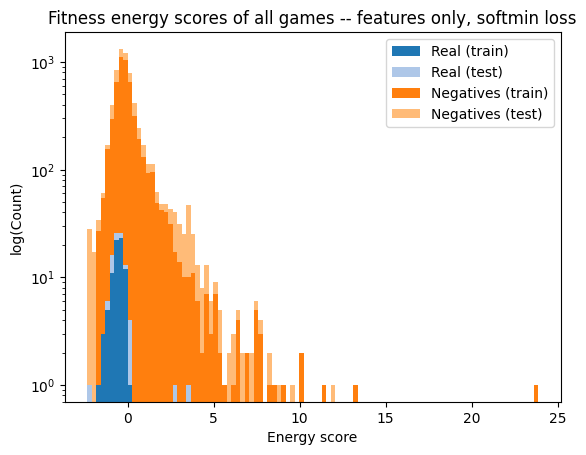

In [16]:
cm = plt.get_cmap('tab20')
plt.hist([train_positive_scores, test_positive_scores, train_negative_scores.flatten(), test_negative_scores.flatten()], 
    stacked=True, bins=100, label=['Real (train)', 'Real (test)', 'Negatives (train)', 'Negatives (test)'],
    color=cm.colors[:4])
plt.title('Fitness energy scores of all games -- features only, softmin loss')
plt.xlabel('Energy score')
plt.ylabel('log(Count)')
plt.semilogy()
plt.legend(loc='best')



In [ ]:
filtered_df = create_filtered_df(fitness_df)
feature_columns = [c for c in filtered_df.columns if c not in NON_FEATURE_COLUMNS]
full_tensor = utils.df_to_tensor(filtered_df, feature_columns)

cv.best_estimator_.fit(full_tensor)

SAVE_MODEL = False
if SAVE_MODEL:
    output_path = '../models/cv_fitness_model_2022_01_09.pkl.gz'
    original_output_path = output_path[:]
    i = 0
    while os.path.exists(output_path):
        output_path = original_output_path + f'_{i}'
        i += 1

    with gzip.open(output_path, 'wb') as f:
        pickle.dump(cv.best_estimator_, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# DEFAULT_FITNESS_FUNCTION_PATH = '../models/cv_fitness_model_2022_12_23.pkl.gz'
# with gzip.open(DEFAULT_FITNESS_FUNCTION_PATH, 'rb') as f:
#     cv_fitness_model = pickle.load(f)

cv_fitness_model = cv.best_estimator_

0.0015186265 0.0130728185 3.0141638e-09


Text(0, 0.5, 'Count')

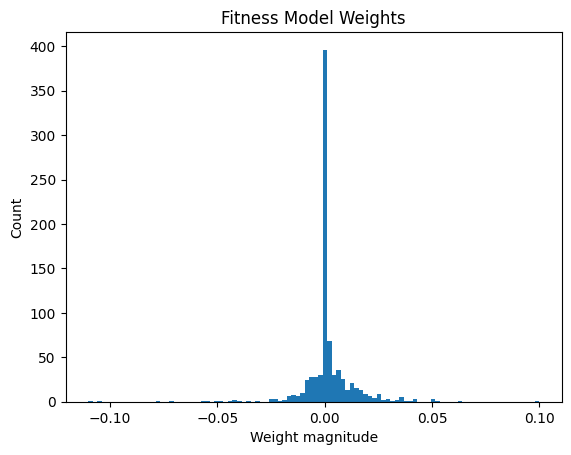

In [31]:
weights = cv.best_estimator_.named_steps['fitness'].model.fc1.weight.data.detach().numpy().squeeze()
bias = cv.best_estimator_.named_steps['fitness'].model.fc1.bias.data.detach().numpy().squeeze()
print(weights.mean(), weights.std(), bias)

plt.hist(weights, bins=100)
plt.title('Fitness Model Weights')
plt.xlabel('Weight magnitude')
plt.ylabel('Count')

In [23]:
feature_columns = [c for c in fitness_df.columns if c not in NON_FEATURE_COLUMNS]
n_top = 10
sorted_indices = np.argsort(weights)
top_weight_indices = sorted_indices[-n_top:]
bottom_weight_indices = sorted_indices[:n_top]

top_features = [feature_columns[i] for i in top_weight_indices][::-1]
bottom_features = [feature_columns[i] for i in bottom_weight_indices]
print(bottom_features)
print(top_features)

['all_variables_used', 'pref_forall_used', 'variable_not_repeated', 'pref_forall_correct_types', 'arg_types_in_receptacles_balls', 'compositionality_structure_1', 'all_preferences_used', 'all_variables_defined', 'arg_types_agent_holds_balls', 'no_nested_logicals']
['arg_types_adjacent_colors_receptacles', 'arg_types_touch_blocks_any_object', 'arg_types_on_ramps_furniture', 'arg_types_adjacent_colors_blocks', 'arg_types_touch_balls_colors', 'arg_types_touch_receptacles_any_object', 'arg_types_adjacent_any_object_room_features', 'arg_types_adjacent_any_object_any_object', 'arg_types_adjacent_large_objects_balls', 'arg_types_on_agent_room_features']


In [24]:
test_param_grid = [
    {
        'fitness__loss_function': [utils.fitness_softmin_hybrid_loss], # [utils.fitness_hinge_loss_with_cross_example],
        'fitness__weight_decay': [0.0, 0.25, 1, 2],  
        'fitness__margin': [1, 2, 4, 8],
        'fitness__beta': [0.25, 1, 2, 4],
        'fitness__lr':  [1e-1, 3e-2, 1e-2, 3e-3],  # [1e-1, 3e-2, 1e-2, 3e-3],
        'fitness__k': [4, 8, 16, 32, 64],
        'fitness__batch_size': [2, 4, 8, 16],  # [1, 4, 8, 16],
        # 'fitness__alpha': [0, 0.25, 0.5, 0.75, 1], # [0, 0.1, 0.2, 0.3],  #
    },
    # {
    # #     'fitness__loss_function': [utils.fitness_log_loss],
    # #     'fitness__weight_decay': [0.0, 0.125, 0.25, 0.5, 1],  
    # #     'fitness__lr': [1e-2, 3e-3, 1e-3, 3e-4],
    # #     'fitness__k': [16, 32, 64, 128],
    # #     'fitness__batch_size': [1, 4, 8, 16],
    # # },
    # # {
    # #     'fitness__loss_function': [utils.fitness_square_square_loss],
    # #     'fitness__weight_decay': [0.0, 0.125, 0.25, 0.5, 1],  
    # #     'fitness__margin': [1, 2, 4],
    # #     'fitness__lr': [1e-2, 3e-3, 1e-3, 3e-4],
    # #     'fitness__k': [16, 32, 64, 128],
    # #     'fitness__batch_size': [1, 4, 8, 16],
    # },
    
]

all_feature_columns = [c for c in filtered_fitness_df.columns if c not in NON_FEATURE_COLUMNS]
model_kwargs = dict(output_activation=nn.Identity())
train_kwargs = dict()
cv_kwargs = dict(refit='single_game_rank')
scoring = utils.build_multiple_scoring_function(
    [utils.evaluate_fitness_overall_ecdf, utils.evaluate_fitness_single_game_rank],
    ['overall_ecdf', 'single_game_rank'],
)

cv, (train_tensor, test_tensor), test_results = utils.model_fitting_experiment(fitness_df, test_param_grid,
    scoring_function=scoring, verbose=1, 
    model_kwargs=model_kwargs, train_kwargs=train_kwargs, cv_kwargs=cv_kwargs)

print(test_results)


Fitting 5 folds for each of 5120 candidates, totalling 25600 fits
{'ecdf': -0.2939230769230769, 'game_rank': 0.867968738079071}


In [27]:
cv_df = pd.concat([
    pd.DataFrame(cv.cv_results_["params"]), 
    pd.DataFrame(cv.cv_results_["mean_test_overall_ecdf"], columns=['ecdf_mean']), 
    pd.DataFrame(cv.cv_results_["std_test_overall_ecdf"], columns=['ecdf_std']), 
    pd.DataFrame(cv.cv_results_["rank_test_overall_ecdf"], columns=['ecdf_rank']),
    pd.DataFrame(cv.cv_results_["mean_test_single_game_rank"], columns=['game_rank_mean']), 
    pd.DataFrame(cv.cv_results_["std_test_single_game_rank"], columns=['game_rank_std']), 
    pd.DataFrame(cv.cv_results_["rank_test_single_game_rank"], columns=['game_rank_rank']),
],axis=1)

cv_df.sort_values(by='ecdf_rank').head(10)

,fitness__batch_size,fitness__beta,fitness__k,fitness__loss_function,fitness__lr,fitness__margin,fitness__n_features,fitness__weight_decay,ecdf_mean,ecdf_std,ecdf_rank,game_rank_mean,game_rank_std,game_rank_rank
151,2,0.25,16,<function fitness_softmin_hybrid_loss at 0x15e...,0.03,2,835,2.0,-0.279879,0.012322,1,0.874128,0.016221,10
467,2,1.00,16,<function fitness_softmin_hybrid_loss at 0x15e...,0.03,1,835,2.0,-0.282274,0.045174,2,0.873008,0.019128,14
43,2,0.25,4,<function fitness_softmin_hybrid_loss at 0x15e...,0.01,4,835,2.0,-0.282363,0.026526,3,0.872214,0.011577,20
471,2,1.00,16,<function fitness_softmin_hybrid_loss at 0x15e...,0.03,2,835,2.0,-0.283122,0.020517,4,0.880365,0.013828,1
475,2,1.00,16,<function fitness_softmin_hybrid_loss at 0x15e...,0.03,4,835,2.0,-0.284451,0.021252,5,0.878997,0.014797,2
479,2,1.00,16,<function fitness_softmin_hybrid_loss at 0x15e...,0.03,8,835,2.0,-0.284980,0.021097,6,0.878190,0.015138,3
1372,4,0.25,8,<function fitness_softmin_hybrid_loss at 0x15e...,0.03,8,835,0.0,-0.285146,0.022085,7,0.865638,0.025716,229
138,2,0.25,16,<function fitness_softmin_hybrid_loss at 0x15e...,0.10,4,835,1.0,-0.285976,0.016720,8,0.873112,0.015316,12
427,2,1.00,8,<function fitness_softmin_hybrid_loss at 0x15e...,0.01,4,835,2.0,-0.286658,0.045426,9,0.869102,0.029562,81
39,2,0.25,4,<function fitness_softmin_hybrid_loss at 0x15e...,0.01,2,835,2.0,-0.286671,0.026386,10,0.870781,0.012667,42


In [28]:
cv_df.sort_values(by='game_rank_rank').head(10)

,fitness__batch_size,fitness__beta,fitness__k,fitness__loss_function,fitness__lr,fitness__margin,fitness__n_features,fitness__weight_decay,ecdf_mean,ecdf_std,ecdf_rank,game_rank_mean,game_rank_std,game_rank_rank
471,2,1.00,16,<function fitness_softmin_hybrid_loss at 0x15e...,0.03,2,835,2.0,-0.283122,0.020517,4,0.880365,0.013828,1
475,2,1.00,16,<function fitness_softmin_hybrid_loss at 0x15e...,0.03,4,835,2.0,-0.284451,0.021252,5,0.878997,0.014797,2
479,2,1.00,16,<function fitness_softmin_hybrid_loss at 0x15e...,0.03,8,835,2.0,-0.284980,0.021097,6,0.878190,0.015138,3
403,2,1.00,8,<function fitness_softmin_hybrid_loss at 0x15e...,0.03,1,835,2.0,-0.291835,0.033605,52,0.877357,0.019419,4
74,2,0.25,8,<function fitness_softmin_hybrid_loss at 0x15e...,0.10,4,835,1.0,-0.307456,0.028017,921,0.875872,0.020202,5
284,2,0.25,64,<function fitness_softmin_hybrid_loss at 0x15e...,0.03,8,835,0.0,-0.292871,0.026893,71,0.875781,0.023425,6
3915,16,0.25,8,<function fitness_softmin_hybrid_loss at 0x15e...,0.10,4,835,2.0,-0.288241,0.027445,13,0.875078,0.017529,7
3855,16,0.25,4,<function fitness_softmin_hybrid_loss at 0x15e...,0.10,8,835,2.0,-0.294435,0.029370,99,0.874870,0.015856,8
1564,4,0.25,64,<function fitness_softmin_hybrid_loss at 0x15e...,0.03,8,835,0.0,-0.289087,0.025252,23,0.874687,0.022415,9
151,2,0.25,16,<function fitness_softmin_hybrid_loss at 0x15e...,0.03,2,835,2.0,-0.279879,0.012322,1,0.874128,0.016221,10


In [29]:
train_positive_scores = cv.best_estimator_.transform(train_tensor[:, 0, :]).detach().squeeze().numpy()
train_negative_scores = cv.best_estimator_.transform(train_tensor[:, 1:, :]).detach().squeeze().numpy()

test_positive_scores = cv.best_estimator_.transform(test_tensor[:, 0, :]).detach().squeeze().numpy()
test_negative_scores = cv.best_estimator_.transform(test_tensor[:, 1:, :]).detach().squeeze().numpy()

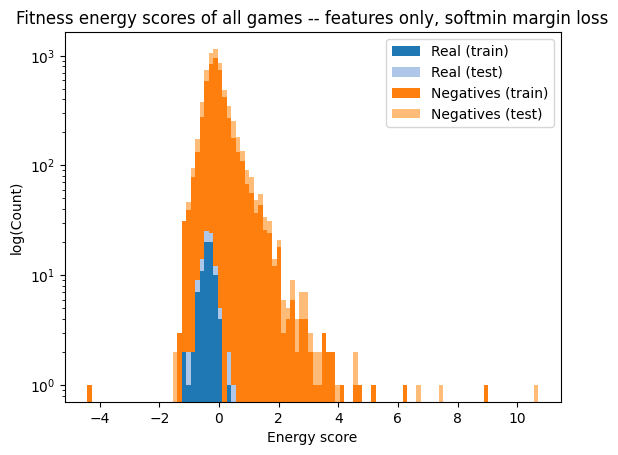

In [34]:
cm = plt.get_cmap('tab20')
plt.hist([train_positive_scores, test_positive_scores, train_negative_scores.flatten(), test_negative_scores.flatten()], 
    stacked=True, bins=100, label=['Real (train)', 'Real (test)', 'Negatives (train)', 'Negatives (test)'],
    color=cm.colors[:4])
plt.title('Fitness energy scores of all games -- features only, softmin margin loss')
plt.xlabel('Energy score')
plt.ylabel('log(Count)')
plt.semilogy()
plt.legend(loc='best')



0.0015186265 0.0130728185 3.0141638e-09


Text(0, 0.5, 'Count')

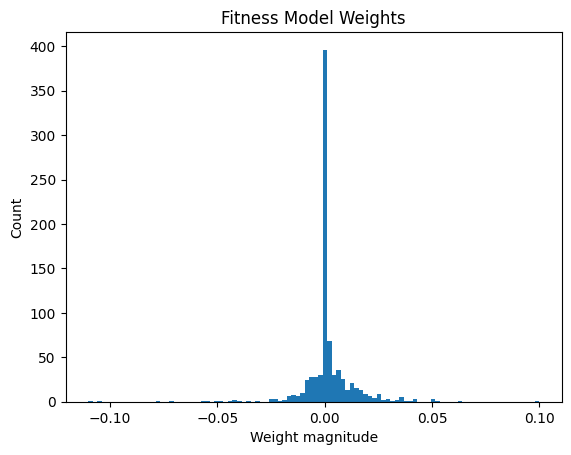

In [32]:
weights = cv.best_estimator_.named_steps['fitness'].model.fc1.weight.data.detach().numpy().squeeze()
bias = cv.best_estimator_.named_steps['fitness'].model.fc1.bias.data.detach().numpy().squeeze()
print(weights.mean(), weights.std(), bias)

plt.hist(weights, bins=100)
plt.title('Fitness Model Weights')
plt.xlabel('Weight magnitude')
plt.ylabel('Count')

## Trying the old hinge loss, but with no negative averaging

In [50]:
test_param_grid = [
    # {
    #     'fitness__loss_function': [utils.fitness_hinge_loss], # [utils.fitness_hinge_loss_with_cross_example],
    #     'fitness__weight_decay': [0.0, 0.25, 1, 2],  
    #     'fitness__margin': [1, 2, 4, 8],
    #     # 'fitness__beta': [0.25, 1, 2, 4],
    #     'fitness__lr':  [1e-1, 3e-2, 1e-2, 3e-3],  # [1e-1, 3e-2, 1e-2, 3e-3],
    #     'fitness__k': [4, 8, 16, 32, 64],
    #     'fitness__batch_size': [4, 8, 16, 32],  # [1, 4, 8, 16],
    #     # 'fitness__alpha': [0, 0.25, 0.5, 0.75, 1], # [0, 0.1, 0.2, 0.3],  #
    # },
    {
        'fitness__loss_function': [utils.fitness_hinge_loss], # [utils.fitness_hinge_loss_with_cross_example],
        'fitness__weight_decay': [0.0, ],  
        'fitness__margin': [1, 2,],
        # 'fitness__beta': [0.25, 1, 2, 4],
        'fitness__lr':  [1e-1, 3e-2,],  # [1e-1, 3e-2, 1e-2, 3e-3],
        'fitness__k': [32, 64],
        'fitness__batch_size': [8, 16],  # [1, 4, 8, 16],
        # 'fitness__alpha': [0, 0.25, 0.5, 0.75, 1], # [0, 0.1, 0.2, 0.3],  #
    },
]

all_feature_columns = [c for c in filtered_fitness_df.columns if c not in NON_FEATURE_COLUMNS]
model_kwargs = dict(output_activation=nn.Identity())
train_kwargs = dict(negative_score_reduction='none')
cv_kwargs = dict(refit='single_game_rank')
scoring = utils.build_multiple_scoring_function(
    [utils.evaluate_fitness_overall_ecdf, utils.evaluate_fitness_single_game_rank],
    ['overall_ecdf', 'single_game_rank'],
)

cv, (train_tensor, test_tensor), test_results = utils.model_fitting_experiment(fitness_df, test_param_grid,
    scoring_function=scoring, verbose=1, 
    model_kwargs=model_kwargs, train_kwargs=train_kwargs, cv_kwargs=cv_kwargs)

print(test_results)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
{'ecdf': -0.2839615384615385, 'game_rank': 0.887499988079071}


In [52]:
cv_df = pd.concat([
    pd.DataFrame(cv.cv_results_["params"]), 
    pd.DataFrame(cv.cv_results_["mean_test_overall_ecdf"], columns=['ecdf_mean']), 
    pd.DataFrame(cv.cv_results_["std_test_overall_ecdf"], columns=['ecdf_std']), 
    pd.DataFrame(cv.cv_results_["rank_test_overall_ecdf"], columns=['ecdf_rank']),
    pd.DataFrame(cv.cv_results_["mean_test_single_game_rank"], columns=['game_rank_mean']), 
    pd.DataFrame(cv.cv_results_["std_test_single_game_rank"], columns=['game_rank_std']), 
    pd.DataFrame(cv.cv_results_["rank_test_single_game_rank"], columns=['game_rank_rank']),
],axis=1)

display(cv_df.sort_values(by='ecdf_rank').head(10))

,fitness__batch_size,fitness__k,fitness__loss_function,fitness__lr,fitness__margin,fitness__n_features,fitness__weight_decay,ecdf_mean,ecdf_std,ecdf_rank,game_rank_mean,game_rank_std,game_rank_rank
13,16,64,<function fitness_hinge_loss at 0x16a806f80>,0.10,2,835,0.0,-0.291829,0.024007,1,0.878385,0.020602,1
15,16,64,<function fitness_hinge_loss at 0x16a806f80>,0.03,2,835,0.0,-0.295144,0.031641,2,0.867214,0.023348,6
3,8,32,<function fitness_hinge_loss at 0x16a806f80>,0.03,2,835,0.0,-0.295585,0.036826,3,0.866367,0.029415,7
7,8,64,<function fitness_hinge_loss at 0x16a806f80>,0.03,2,835,0.0,-0.296174,0.041077,4,0.867995,0.025583,5
5,8,64,<function fitness_hinge_loss at 0x16a806f80>,0.10,2,835,0.0,-0.296600,0.037860,5,0.877292,0.020579,2
9,16,32,<function fitness_hinge_loss at 0x16a806f80>,0.10,2,835,0.0,-0.296870,0.027331,6,0.866094,0.017550,8
1,8,32,<function fitness_hinge_loss at 0x16a806f80>,0.10,2,835,0.0,-0.296914,0.032639,7,0.875365,0.023545,3
10,16,32,<function fitness_hinge_loss at 0x16a806f80>,0.03,1,835,0.0,-0.304624,0.034510,8,0.859557,0.022322,12
14,16,64,<function fitness_hinge_loss at 0x16a806f80>,0.03,1,835,0.0,-0.304825,0.044510,9,0.856354,0.030779,14
0,8,32,<function fitness_hinge_loss at 0x16a806f80>,0.10,1,835,0.0,-0.307286,0.045906,10,0.872227,0.021475,4


In [53]:
cv_df.sort_values(by='game_rank_rank').head(10)

,fitness__batch_size,fitness__k,fitness__loss_function,fitness__lr,fitness__margin,fitness__n_features,fitness__weight_decay,ecdf_mean,ecdf_std,ecdf_rank,game_rank_mean,game_rank_std,game_rank_rank
13,16,64,<function fitness_hinge_loss at 0x16a806f80>,0.10,2,835,0.0,-0.291829,0.024007,1,0.878385,0.020602,1
5,8,64,<function fitness_hinge_loss at 0x16a806f80>,0.10,2,835,0.0,-0.296600,0.037860,5,0.877292,0.020579,2
1,8,32,<function fitness_hinge_loss at 0x16a806f80>,0.10,2,835,0.0,-0.296914,0.032639,7,0.875365,0.023545,3
0,8,32,<function fitness_hinge_loss at 0x16a806f80>,0.10,1,835,0.0,-0.307286,0.045906,10,0.872227,0.021475,4
7,8,64,<function fitness_hinge_loss at 0x16a806f80>,0.03,2,835,0.0,-0.296174,0.041077,4,0.867995,0.025583,5
15,16,64,<function fitness_hinge_loss at 0x16a806f80>,0.03,2,835,0.0,-0.295144,0.031641,2,0.867214,0.023348,6
3,8,32,<function fitness_hinge_loss at 0x16a806f80>,0.03,2,835,0.0,-0.295585,0.036826,3,0.866367,0.029415,7
9,16,32,<function fitness_hinge_loss at 0x16a806f80>,0.10,2,835,0.0,-0.296870,0.027331,6,0.866094,0.017550,8
8,16,32,<function fitness_hinge_loss at 0x16a806f80>,0.10,1,835,0.0,-0.307833,0.017288,11,0.864206,0.014641,9
4,8,64,<function fitness_hinge_loss at 0x16a806f80>,0.10,1,835,0.0,-0.313145,0.040716,14,0.862461,0.027370,10


In [54]:
train_positive_scores = cv.best_estimator_.transform(train_tensor[:, 0, :]).detach().squeeze().numpy()
train_negative_scores = cv.best_estimator_.transform(train_tensor[:, 1:, :]).detach().squeeze().numpy()

test_positive_scores = cv.best_estimator_.transform(test_tensor[:, 0, :]).detach().squeeze().numpy()
test_negative_scores = cv.best_estimator_.transform(test_tensor[:, 1:, :]).detach().squeeze().numpy()

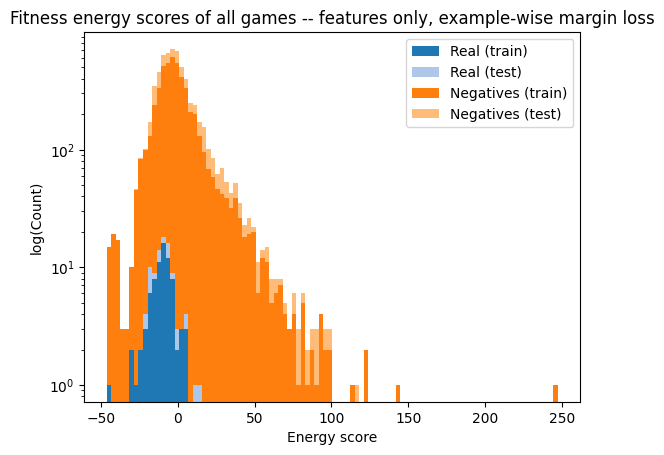

In [49]:
cm = plt.get_cmap('tab20')
plt.hist([train_positive_scores, test_positive_scores, train_negative_scores.flatten(), test_negative_scores.flatten()], 
    stacked=True, bins=100, label=['Real (train)', 'Real (test)', 'Negatives (train)', 'Negatives (test)'],
    color=cm.colors[:4])
plt.title('Fitness energy scores of all games -- features only, example-wise margin loss')
plt.xlabel('Energy score')
plt.ylabel('log(Count)')
plt.semilogy()
plt.legend(loc='best')

